<center>

# Predictive modeling of bearing temperature

</center>

   - **Data preprocessing and exploration** : This marks the most important step in analyzing and
     modeling the data. Some of the key components are :
     
        1) Spotting missing observation and either imputing it or removing it
        
        2) Analyze relation of each covariate with target
        
        3) Spotting outlier from distribution plot, but should not be removed initially.
        
        
   - **Feature Engineering**: Not all available features justify the target, so it becomes necessary  to        model using only the important features. Also some extra features can be engineered by 
     introducing higher order polynomial
     
        1) Using Xgboost to filter out most important covariates
      
        
        
   - **Model fitting using important covariates** : Various models will be used to fit the train data, 
     and their performance on train data will be used as a metric to pick the best models. After 
     picking the best model, it will be used to improve the performance. Some of the elements are :
     
       1) Outlier detection
       
       2) Higher order polynomial added
       
       
   - **Model testing** : The optimized model will be tested on supplied test data to quantify the 
     effectiveness of the model
     
     
   - **Conclusion** : Some details and intuition about using a particular method will be discussed.

In [75]:
# importing necessary functions and packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, FunctionTransformer, PolynomialFeatures

<center>

###  Data exploration and preprocessing

</center>

In [2]:
# importing data set
data = pd.read_csv('SampleData.csv')

# Glimpse of data
data.head()


,TimeStamp,Device,Power,Rotor_Speed,Wind_Speed,Ambient_Temperature,Target_Temp
0,1/1/2017 0:00,WT-001,-4.960554,0.0,8.247060,0.651978,4.779412
1,1/1/2017 0:10,WT-001,-5.020246,0.0,8.426003,0.589799,4.743060
2,1/1/2017 0:20,WT-001,-5.035249,0.0,8.130890,0.544098,4.700070
3,1/1/2017 0:30,WT-001,-4.972121,0.0,7.754125,0.452907,4.674818
4,1/1/2017 0:40,WT-001,-4.941651,0.0,8.085228,0.437470,4.654494


In [3]:
# Specifying features and target
X_features = ['Power', 'Rotor_Speed', 'Wind_Speed','Ambient_Temperature']
Y_target = ['Target_Temp']
Time_var = ['TimeStamp']

In [4]:
# Analyzing missing value
print(pd.isnull(data).sum(axis = 0))

TimeStamp              0
Device                 0
Power                  0
Rotor_Speed            0
Wind_Speed             0
Ambient_Temperature    0
Target_Temp            0
dtype: int64


**Remarks** :

 - No missing observation
 

In [5]:
# function to preprocess and split data
def preprocess(data, var_time):
    data['TimeStamp'] =  pd.to_datetime(data['TimeStamp'], format='%m/%d/%Y %H:%M')
    year = pd.DatetimeIndex(data['TimeStamp']).year
    
    train_data = data.loc[year == 2017]
    test_data = data.loc[year == 2018]
    
    return train_data, test_data

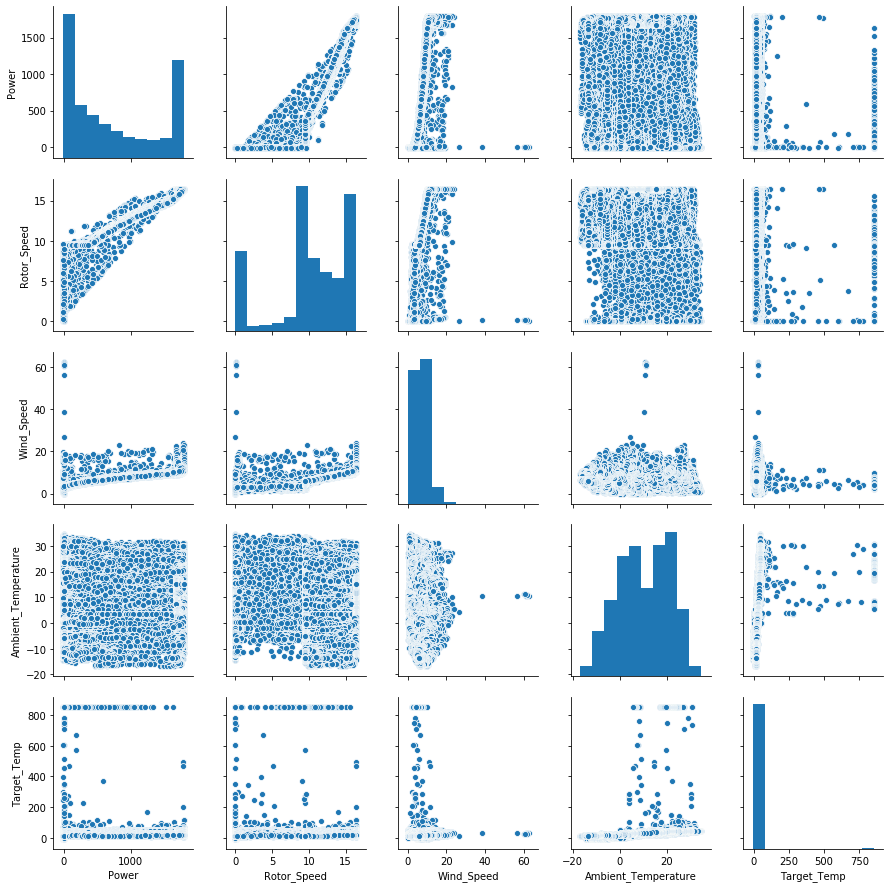

In [6]:
# Scatterplot or correlation plot : study the impact of covariates on target
train_data, test_data = preprocess(data, Time_var)
sns.pairplot(train_data[X_features + Y_target])

**Remarks about above plot** :

   * Wind_Speed, Rotor_Speed and Power might influence Target_Temp
   
   * Ambient_Temp shows positive relation with Target_Temp
   
   * Power shows negative value in some region

<center>

###  Feature Engineering

</center>


[01:23:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


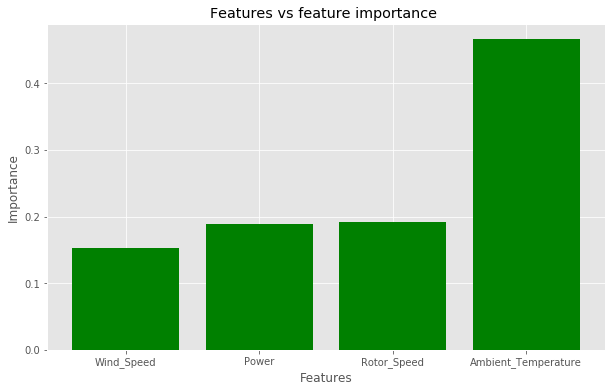

In [7]:
# Feature importance using Xgboost
def FeatureImportance(x, y):
    estimator = XGBRegressor()
    estimator.fit(x, y)
    feature_importance = estimator.feature_importances_
    return feature_importance

X_imp = FeatureImportance(train_data[X_features], train_data[Y_target])


# plotting the importance
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))

var = [X_features[i] for i in np.argsort(X_imp)]
value = [X_imp[i] for i in np.argsort(X_imp)]
x_pos = [i for i, _ in enumerate(var)]

plt.bar(x_pos, value, color='green')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Features vs feature importance ")
plt.xticks(x_pos, var)
plt.show()
    
    

**Remarks about above plot** : 

   * Ambient temperature is the most important covariate
   
   * Rotor and Power are the next most important ones
   
   * Wind speed shows positive importance, but it has high correlation 
     with power and rotor speed
     
   * Features with importance > 0.1 are retained
    

<center>

###  Model Fitting 

</center>

**Step 1** : scripting a generalized modeling code with pipeline

In [8]:
# Genralized code incorporating pipeline
class RegressionModel:
    def __init__(self, model_list, params={}, n_iter=1, cv=5):
        if type(model_list) == list:
            self.pipeline = Pipeline(model_list)
            self.model = RandomizedSearchCV(self.pipeline, param_distributions=params, n_iter=n_iter, cv=cv, scoring = 'neg_mean_squared_error')
        else:
            self.model = Pipeline([('clf', model_list())])
            
    def fit(self, x, y):
        self.model.fit(x, y)
        
    def predict(self, x):
        return self.model.predict(x)
  
    def evaluate(self, x, y):
        return np.sqrt(mean_squared_error(y, self.predict(x)))

**Step 2** : Comparing performance of certain models.

[01:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:43:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:43:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:43:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:43:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


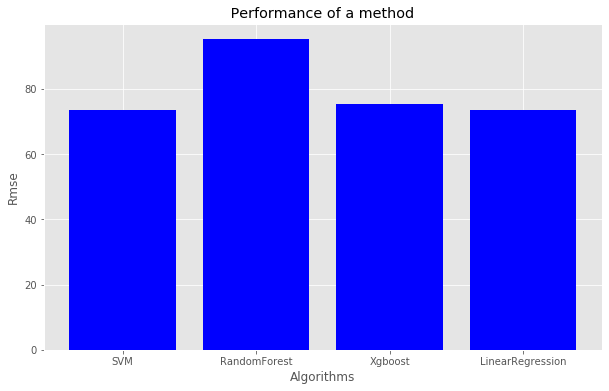

In [9]:
Model_list = {'SVM':SVR(), 'RandomForest':RandomForestRegressor(), 'Xgboost':XGBRegressor(), 'LinearRegression':LinearRegression()}
# Model fitting
warnings.filterwarnings("ignore")
rmse1 = []
predict1 = {}
for i in Model_list.keys():
    model1 = RegressionModel([(i, Model_list[i])])
    model1.fit(train_data[X_features], train_data[Y_target])
    predict1[i] = model1.predict(train_data[X_features])
    rmse1.append(np.sqrt(-(model1.model.best_score_)))
    
# plot the performance
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))

var = Model_list.keys()
value = rmse1
x_pos = [i for i, _ in enumerate(var)]

plt.bar(x_pos, value, color='blue')
plt.xlabel("Algorithms")
plt.ylabel("Rmse")
plt.title(" Performance of a method ")
plt.xticks(x_pos, var)
plt.show()

**Remarks about above plot :**
   
   * The RMSE is too high for any of the modeling techniques
   
   * Although SVM and Linear Regression does better, Xgboost will be used for further modeling and analysis, due to its flexibilty and tremendous speed gain over other methods

###### Model 1 : RMSE is high, could be due to anomaly or outliers

**Step 3** - Detecting anomaly and filtering actual data

Text(0.5, 1.0, ' Before Removing Anomaly ')

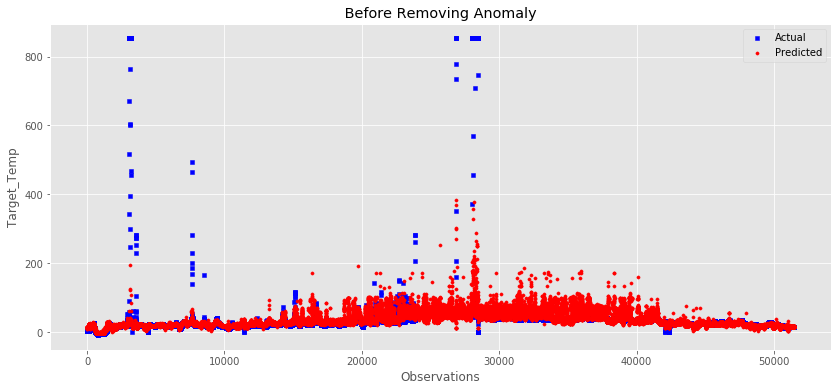

In [18]:
# Plot of actual target vs predicted target before removing anomalous data points
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(range(1, len(train_data[Y_target])+1, 1), train_data[Y_target], s=10, c='b', marker="s", label='Actual')
ax1.scatter(range(1, len(train_data[Y_target])+1, 1), predict1['Xgboost'], s=10, c='r', marker="o", label='Predicted')
ax1.legend()
plt.xlabel("Observations")
plt.ylabel("Target_Temp")
plt.title(" Before Removing Anomaly ")

**Remarks about above plot**:
   
   * The algorithms seems to suffer, since the rmse is too high
   
   * The existence of anomaly or outliers is hampering the model
   
   * The visualization of residual error or isolation forest is to be implemented to remove outliers. 

In [13]:
class RemoveAnomalies:
    def __init__(self, model_class=IsolationForest):
        self.estimator = model_class()
        self.pred_anomalies = []
  
    def fit_transform(self, x, y):
        tmp = pd.DataFrame(y)
        self.estimator.fit(tmp)
        self.pred_anomalies = self.estimator.predict(tmp)
        keep_index = np.where(self.pred_anomalies>0)[0]
        return x.iloc[keep_index], y.iloc[keep_index]
    
    def get_anomalies(self):
        return self.pred_anomalies

Text(0.5, 1.0, ' Identifying anomalous point using Isolation Forest ')

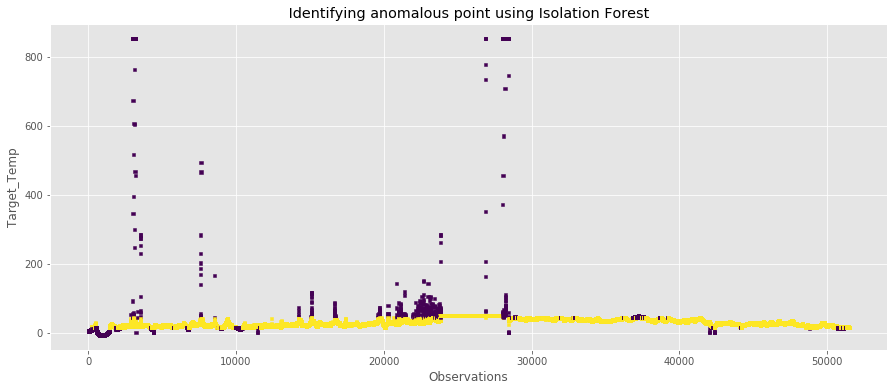

In [16]:
# Creating new train data after removing anomalous points
anomaly = RemoveAnomalies()
new_train_x, new_train_y = anomaly.fit_transform(train_data[X_features], train_data[Y_target])

# plot to show anomalous data points
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(range(1, len(train_data[Y_target]) + 1, 1), train_data[Y_target], s=10, c = anomaly.pred_anomalies > 0.2, marker="s")

plt.xlabel("Observations")
plt.ylabel("Target_Temp")
plt.title(" Identifying anomalous point using Isolation Forest ")

**Remarks about above plot**:
   
   * The yellow points are non amonalous points
   
   * The dark points are anomalous point

[10:23:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The rmse of model2 on train data is : 4.460382592073966


Text(0.5, 1.0, ' After Removing Anomaly ')

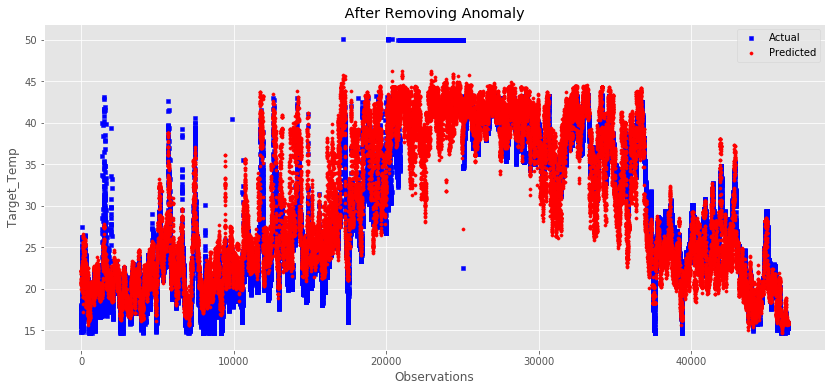

In [68]:
# Modeling after removing anomalous points
model2 = RegressionModel([('Xgboost', XGBRegressor())])
model2.fit(new_train_x, new_train_y)
predict2 = model2.predict(new_train_x)
print ("{0} {1}".format('The rmse of model2 on train data is :', model2.evaluate(new_train_x, new_train_y)))

# Plot of actual target vs predicted after removing anomaly
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(range(1, len(new_train_y)+1, 1), new_train_y, s=10, c='b', marker="s", label='Actual')
ax1.scatter(range(1, len(new_train_y)+1, 1), predict2, s=10, c='r', marker="o", label='Predicted')
ax1.legend()
plt.xlabel("Observations")
plt.ylabel("Target_Temp")
plt.title(" After Removing Anomaly ")

###### The RMSE of model2 on train data is : 4.43

###### Model 2 : significant improvement, RMSE is down to 4.46

**Step 4** - Effect of scaling and higher order polynomial

In [67]:
model3 = RegressionModel([
    ('pf', PolynomialFeatures(degree=3, interaction_only=False,  include_bias=True)),
    ('scaler', RobustScaler()),
    ('boxcox', PowerTransformer()),
    ('Xgboost', XGBRegressor())
])
model3.fit(new_train_x, new_train_y)
print ("{0} {1}".format('The rmse of model3 on train data is :', model3.evaluate(new_train_x, new_train_y)))

[10:22:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:22:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:22:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:22:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:22:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The rmse of model3 on train data is : 4.4392948154557255


###### The RMSE of model3 on train data is : 4.43

###### Model 3 : slight improvement in train data, RMSE is down to 4.46

##### Model 2 and Model 3 will be tested on test data, to finalize the best model

<center>

### Model testing

</center>



The rmse of model2 on train data is : 4.460382592073966
The rmse of model2 on test data is : 3.9149528158059836
The rmse of model3 on train data is : 4.4392948154557255
The rmse of model3 on test data is : 3.952315770983208


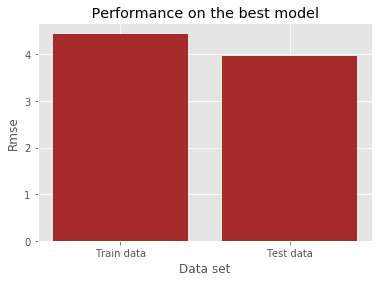

In [74]:
# Train and test performance on Model2 and Model3
print ("{0} {1}".format('The rmse of model2 on train data is :', model2.evaluate(new_train_x, new_train_y)))
print ("{0} {1}".format('The rmse of model2 on test data is :', model2.evaluate(test_data[X_features], test_data[Y_target])))

print ("{0} {1}".format('The rmse of model3 on train data is :', model3.evaluate(new_train_x, new_train_y)))
print ("{0} {1}".format('The rmse of model3 on test data is :', model3.evaluate(test_data[X_features], test_data[Y_target])))


# Model performance on train and test data
comparison_var = ['Train data', 'Test data']
comparison_value = [model3.evaluate(new_train_x, new_train_y), model3.evaluate(test_data[X_features], test_data[Y_target])]

x_pos = [i for i, _ in enumerate(comparison_var)]

plt.bar(x_pos, comparison_value, color='brown')
plt.xlabel("Data set")
plt.ylabel("Rmse")
plt.title(" Performance on the best model ")
plt.xticks(x_pos, comparison_var)
plt.show()

**Remarks** :

   * The RMSE of train data is 4.46
    
   * The RMSE of test data is 3.91

Text(0.5, 1.0, 'Test data')

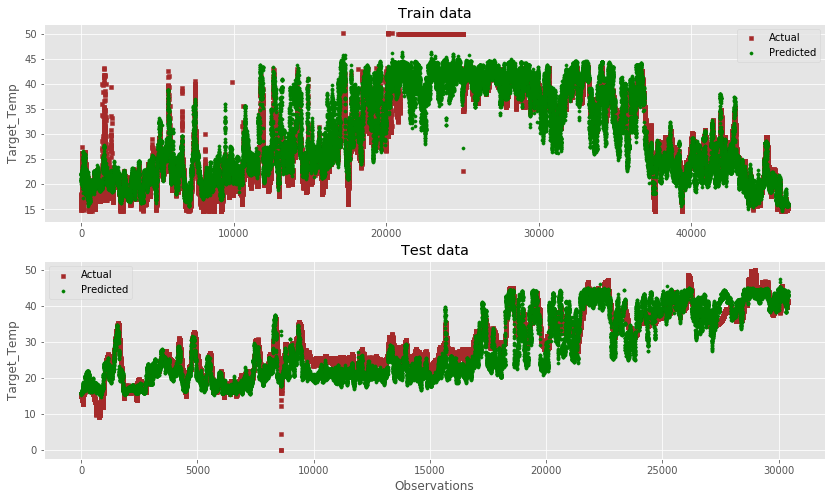

In [54]:
# Comparison plot for original taget and predicted target
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.scatter(range(1, len(new_train_y)+1, 1), new_train_y, s=10, c='brown', marker="s", label='Actual')
ax1.scatter(range(1, len(new_train_y)+1, 1), model2.predict(new_train_x), s=10, c='green', marker="o", label='Predicted')
ax1.legend()
ax1.set_ylabel('Target_Temp')
ax1.set_title('Train data')

ax2.scatter(range(1, len(test_data[Y_target])+1, 1), test_data[Y_target], s=10, c='brown', marker="s", label='Actual')
ax2.scatter(range(1, len(test_data[Y_target])+1, 1), model2.predict(test_data[X_features]), s=10, c='green', marker="o", label='Predicted')
ax2.legend()
ax2.set_xlabel('Observations')
ax2.set_ylabel('Target_Temp')
ax2.set_title('Test data')

### Conclusion

**The best obtained results for train and test data are :**

  * Rmse on train data - 4.46

  * Rmse on test data - 3.91
  
**The models tried :**

  * Model 1 - No cleaning or transformation of train data. High rmse

  * Model 2 - Anomaly or outliers detected and removed. Significant improvement in model performance
  
  * Model 3 - Further tranformation is applied to Model 2, shows improvement in train data but not in     test data
  
  Best Model - is Model 2, using Xgboost with default parameters and no input features transformation
  
**The techniques tried, but not shown in this notebook :**

  * Some power feature in train data are negative, which could be due to forcibly trying to stop 
    turbine. Since, at this point turbine is not in actual production, this observation either should 
    be removed or transformed. Changing the negative power to 0 or removing them does not affect the 
    model
    
  * Xgboost hyperparameter optimization also do not show any significant improvement, so default conditions are accepted
  
  * Analysis of residual error to remove anomaly is done, but finally isolation forest is accepted.
  
Various methods along with tweaking of their hyperparameters do not show any significant improvement, as does the removal of outliers. Also, since this is a time series data set, the bearing temperature at T shows a great correlation with its temperature at T-1, using time series feature can enhance the predictibility of model.

**What do you think is the reason that we are not using random training and test as would normally be done ?**


The resason for using training data of 2017 to predict for 2018 : The aim here is to predict future condition rather than forecast. Having a trained model at hand, can give a fair idea about the performance of bearing in the future given a set of input parameters. The prior prediction can help in better planning for preventive maintenance.